In [1]:
import numpy as np

import os
#Choose GPU 0 as a default
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Activation
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import Model
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

import sys
sys.path.append('/home/zsteineh/cnn_hilbert/cnn_hilbert_workspace')
import hilbert_DL_utils
from hilbert_DL_utils import load_data

import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

In [2]:
pretask_type = ['rel_pos', 'sig_tran']
model_types = ['pretask', 'tl', 'ts']
sp = '/home/zsteineh/ez_ssl_results/'
name = pretask_type[0]+model_types[1]+'_acc_dict'
with open(sp+'obj/' + name + '.pkl', 'rb') as f:
        acc_dict = pickle.load(f)

In [3]:
sbj_accs = []
for pretask in pretask_type:
    for model in model_types:
        name = pretask+model+'_acc_dict'
        with open(sp+'obj/' + name + '.pkl', 'rb') as f:
                acc_dict = pickle.load(f)
        for sbj in acc_dict:
            for accs_set in acc_dict[sbj]:
                accs = [pretask, model, sbj]
                for acc in accs_set:
                    accs.append(acc)
                sbj_accs.append(accs)
sbj_acc_df = pd.DataFrame.from_records(sbj_accs, columns = ['Pretask','Model','Subject', 'Train', 'Val', 'Test'])
print(sbj_acc_df)

      Pretask    Model   Subject     Train       Val      Test
0     rel_pos  pretask  a0f66459  0.457067  0.497354  0.475806
1     rel_pos  pretask  a0f66459  0.520476  0.534392  0.526882
2     rel_pos  pretask  a0f66459  0.565390  0.523810  0.500000
3     rel_pos  pretask  c95c1e82  0.494297  0.446154  0.400000
4     rel_pos  pretask  c95c1e82  0.437262  0.446154  0.366667
..        ...      ...       ...       ...       ...       ...
211  sig_tran       ts  ec168864  0.901754  0.887324  0.902174
212  sig_tran       ts  ec168864  0.888596  0.830986  0.894022
213  sig_tran       ts  b45e3f7b  0.828926  0.811258  0.767016
214  sig_tran       ts  b45e3f7b  0.805785  0.761589  0.769634
215  sig_tran       ts  b45e3f7b  0.813223  0.751656  0.746073

[216 rows x 6 columns]


/home/zsteineh/anaconda3/envs/ez_ss_dl_venv/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [ ]:
num_sbj = len(set(sbj_acc_df['Subject'].tolist()))
sbjs_list = list(set(sbj_acc_df['Subject'].tolist()))
pretask_data = sbj_acc_df.loc[sbj_acc_df['Pretask'] == pretask_type[0]]
# test_avgs = pd.DataFrame(columns=['Model', 'Subject', 'Test'])

for model in model_types:
    pretask_model_data = pretask_data.loc[pretask_data['Model'] == model]
#     print(pretask_model_data.groupby('Subject')['Test'].mean())
    model_list = [model] * num_sbj
    avg_list = pretask_model_data.groupby('Subject')['Test'].mean().tolist()
    print(model_list)
    print(sbjs_list)
    print(avg_list)
    
    combined_list = [[m,s,t] for m in model_types for s in sbjs_list for t in avg_list]
#     print(combined_list)
    

#     test_avgs = test_avgs.append(pd.DataFrame(avg_list, columns = ['Test']), ignore_index = True)
# print(test_avgs)

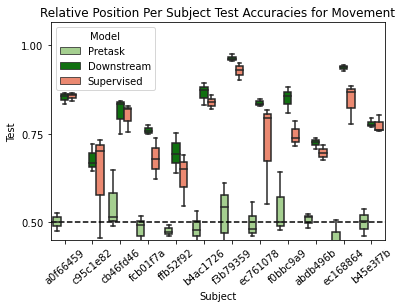

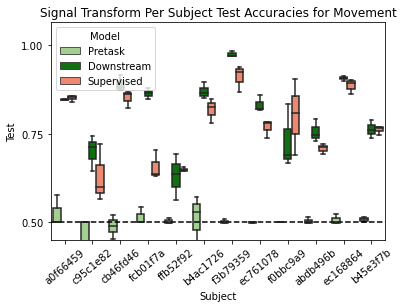

In [39]:
correct_model_labels = ['Pretask', 'Downstream', 'Supervised']
correct_pretask_labels = {'rel_pos':'Relative Position', 'sig_tran':'Signal Transform'}
my_pal = {"pretask": '#A1DA85', "tl": 'g', "ts": '#FF7D5D'}
# plot some subject specific stuff

for pre in pretask_type:
    my_plt = sns.boxplot(x = 'Subject', y = 'Test', hue = 'Model', 
                      data = sbj_acc_df.loc[sbj_acc_df['Pretask'] == pre], palette=my_pal)
    my_plt.set_xticklabels(my_plt.get_xticklabels(),rotation=40)
    my_plt.set_title(correct_pretask_labels[pre]+' Per Subject Test Accuracies for Movement')
    my_plt.set_ylim([(1/2)-.05,1.065])
    my_plt.set_yticks([.5,.75,1])
    leg = my_plt.get_legend()
    for t, l in zip(leg.texts, correct_model_labels): t.set_text(l)
    my_plt.axhline(1/2,c='k',linestyle='--')
    plt.show()

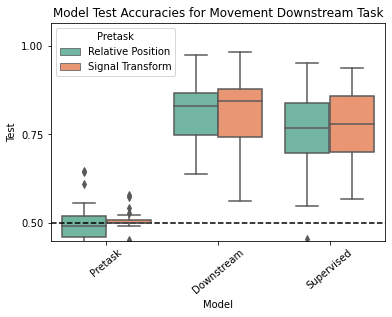

In [37]:
my_plt = sns.boxplot(x = 'Model', y = 'Test', hue = 'Pretask', data = sbj_acc_df, palette='Set2')
my_plt.set_xticklabels(my_plt.get_xticklabels(),rotation=40)
my_plt.set_title('Model Test Accuracies for Movement Downstream Task')
my_plt.set_ylim([(1/2)-.05,1.065])
my_plt.set_yticks([.5,.75,1])
my_plt.axhline(1/2,c='k',linestyle='--')
my_plt.set_xticklabels(correct_model_labels)
leg = my_plt.get_legend()
for t, l in zip(leg.texts, correct_pretask_labels.values()): t.set_text(l)
plt.show()

In [ ]:
# Kruskal-Wallis test (non-parametric ANOVA)
print(pg.friedman(data=sbj_acc_df, dv='Test', within='Model', subject='Subject')['p-unc'])

# Wilcoxon tests (non-parametric t-tests)
# Computes tests at the data snapshot
p_vals = []
n_models = len(model_types)
for i in range(n_models):
    for j in range(i+1,n_models):
        val1 = sbj_acc_df[(sbj_acc_df['Model'] == model_types[i])].iloc[:,5].values
        val2 = sbj_acc_df[(sbj_acc_df['Model'] == model_types[j])].iloc[:,5].values
        p_vals.append(float(pg.wilcoxon(val1, val2)['p-val']))

# Correct for multiple comparisons
_,p_vals = pg.multicomp(np.asarray(p_vals), alpha=0.05, method='fdr_bh')

pval_df = np.zeros([n_models,n_models])
q = 0
for i in range(n_models):
    for j in range(i+1,n_models):
        pval_df[i,j] = p_vals[q]
        q += 1

# Create output df with p_values
df_pval = pd.DataFrame(pval_df,columns=model_types,index=model_types)
df_pval[df_pval==0] = np.nan
print(df_pval)

In [ ]:
# Kruskal-Wallis test (non-parametric ANOVA)
print(pg.friedman(data=sbj_acc_df, dv='Test', within='Pretask', subject='Subject')['p-unc'])
# Looks like this isn't significant between the diff pretasks

In [ ]:
# Wilcoxon tests (non-parametric t-tests)
# Computes tests at the data snapshot
p_vals = []
n_models = len(model_types)
n_pretasks = len(pretask_type)

for pretask in range(n_pretasks):
    print("running model comparison stats for", pretask_type[pretask])
    pretask_df = sbj_acc_df[(sbj_acc_df['Pretask'] == pretask_type[pretask])]
    p_vals = []
    for i in range(n_models):
        for j in range(i+1,n_models):
            val1 = pretask_df[(pretask_df['Model'] == model_types[i])].iloc[:,5].values
            val2 = pretask_df[(pretask_df['Model'] == model_types[j])].iloc[:,5].values
            p_vals.append(float(pg.wilcoxon(val1, val2)['p-val']))

    # Correct for multiple comparisons
    _,p_vals = pg.multicomp(np.asarray(p_vals), alpha=0.05, method='fdr_bh')

    pval_df = np.zeros([n_models,n_models])
    q = 0
    for i in range(n_models):
        for j in range(i+1,n_models):
            pval_df[i,j] = p_vals[q]
            q += 1

    # Create output df with p_values
    df_pval = pd.DataFrame(pval_df,columns=model_types,index=model_types)
    df_pval[df_pval==0] = np.nan
    print(df_pval)